In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as func
import random
from tqdm import tqdm
import numpy as np
from GRUnet import InitGRU, KalmanNetNN

In [6]:
# training params
N_E = 50                                                # total samples
N_Epochs = 20                                           # epochs
train_split = 0.8                                       # train_cv_split
train_samples = int(train_split*N_E)                    # number of training samples
N_B = train_samples                                     # batch size, default full batch
loss_fn = nn.MSELoss()                                  # loss function
N_CV = N_E - train_samples                              # number of cv samples
learningRate = 1e-4                                     # learning rate
weightDecay = 1e-5                                      # regularizer, for optimizer

In [ ]:
# data input
A =                                                     # latest A
C =                                                     # latest C
yt =                                                    # shape: [ n_samples : timesteps : spikes dimensions ]  y t
latent_states =                                         # shape: [ n_samples : timesteps : states dimensions ]  x t|t-1

In [7]:
# initialize model
m=5                                                     # states dimensions
n=182                                                   # spikes dimensions
T = 20                                                  # time steps
F = torch.tensor(A).float()                             # A_values
H = torch.tensor(C).float()                             # C_values
K0 = torch.tensor(np.random.rand(m,n)).float()          # KalmanGain at t0, not used for now

initGRU = InitGRU(F,H,K0,m,n,T)

In [9]:
# data
train_input = torch.tensor(yt).float()                          
all_target = torch.tensor(latent_states).float()                
all_target_t0 = torch.tensor(latent_states[:,0,:]).float()      # shape: [ n_samples : states dimensions ]              x 1|0

In [10]:
# train validation split
random.seed(42)
train_index = random.sample(range(N_E), train_samples)
cv_index = list(set(range(50)) - set(train_index))

y_training = train_input[train_index].clone()
y_training_cv = train_input[cv_index].clone()
train_target = all_target[train_index].clone()
cv_target = all_target[cv_index].clone()
latent_states_t0_train = all_target_t0[train_index].clone()
latent_states_t0_cv = all_target_t0[cv_index].clone()

In [11]:
kn = KalmanNetNN()
kn.Build(initGRU)

In [12]:
optimizer = torch.optim.Adam(kn.parameters(), lr=learningRate, weight_decay=weightDecay)                                 

In [14]:
# save MSE
MSE_cv_linear_batch = torch.empty([N_CV])
MSE_cv_linear_epoch = torch.empty([N_Epochs])
MSE_cv_dB_epoch = torch.empty([N_Epochs])
MSE_train_linear_batch = torch.empty([N_B])
MSE_train_linear_epoch = torch.empty([N_Epochs])
MSE_train_dB_epoch = torch.empty([N_Epochs])

In [15]:
x_out_cv = torch.empty(N_CV,initGRU.m, initGRU.T)

for i in range(N_Epochs):
    # validation
    for c in tqdm(range(0, N_CV),desc='validation'):
        y_cv = y_training_cv[c, :, :]
        kn.InitSequence(latent_states_t0_cv[c])

        for t in range(0, initGRU.T):
            x_out_cv[c,:, t] = kn(y_cv[t,:])

        # Compute validation Loss
        MSE_cv_linear_batch[c] = loss_fn(x_out_cv[c], cv_target[c, :].T).item()
    # Average
    MSE_cv_linear_epoch[i] = torch.mean(MSE_cv_linear_batch)
    MSE_cv_dB_epoch[i] = 10 * torch.log10(MSE_cv_linear_epoch[i])
    print(i, "MSE cv :", MSE_cv_linear_epoch[i])

    # training
    kn.train()
    kn.init_hidden()
    Batch_Optimizing_LOSS_sum = 0
    spike_loss = torch.empty([train_samples,initGRU.T,initGRU.n])
    for j in tqdm(range(0, N_B),desc='training_samples'):
        if N_B == train_samples:
            n_e = j
        else:
            n_e = random.randint(0, N_E - 1)
        kn.InitSequence(latent_states_t0_train[n_e])

        x_out_training = torch.empty(initGRU.m, initGRU.T)
        
        for t in range(0, T):
            x_out_training[:, t] = kn(y_training[n_e,t,:])
            spike_loss[n_e,t,:] = kn.m1y
        # Compute Training Loss
        LOSS = loss_fn(x_out_training, train_target[n_e].T)
        MSE_train_linear_batch[n_e] = LOSS.item()

        Batch_Optimizing_LOSS_sum = Batch_Optimizing_LOSS_sum + LOSS

    MSE_train_linear_epoch[i] = torch.mean(MSE_train_linear_batch)
    MSE_train_dB_epoch[i] = 10 * torch.log10(MSE_train_linear_epoch[i])

    optimizer.zero_grad()
    Batch_Optimizing_LOSS_mean = Batch_Optimizing_LOSS_sum / N_B
    Batch_Optimizing_LOSS_mean.backward()
    optimizer.step()
    print(i, "MSE Training :", MSE_train_linear_epoch[i])

validation: 100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


0 MSE cv : tensor(909782.3750)


training_samples: 100%|██████████| 40/40 [03:41<00:00,  5.54s/it]


0 MSE Training : tensor(1735658.2500)


validation: 100%|██████████| 10/10 [00:56<00:00,  5.61s/it]


1 MSE cv : tensor(228.3479)


training_samples: 100%|██████████| 40/40 [03:43<00:00,  5.59s/it]


1 MSE Training : tensor(163.5904)


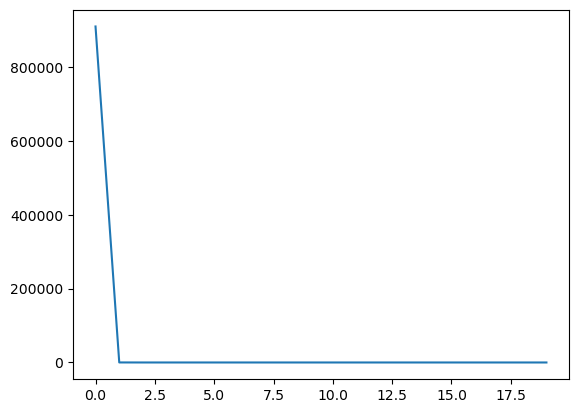

In [51]:
plt.plot(MSE_cv_linear_epoch)

In [36]:
# output of validation set
x_out_cv.shape

torch.Size([5, 20])

In [32]:
# NRMSE for training spikes : lastest epoch
np.sqrt(np.mean((spike_loss.detach() - y_training).numpy() ** 2)) / np.sqrt(np.var(y_training.numpy()))

2.7984452